# Prototype: Field of View Projection
This notebook demonstrates how player positions are filtered based on the camera field of view projected onto the pitch.
Players outside the visible area are excluded.


In [1]:
import numpy as np
import jdata as jd
from floodlight import XY, Pitch
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.prepared import prep

from src.constants import MATCH_LENGTH, POSITIONS_4231, POSITIONS_352


### Data preparation

In [2]:
# set match id
match_id = "DFL-MAT-0002UK"

In [3]:
# Import data
intersections = {
    "SF": jd.load(f"./data/pitch_intersections/SF_{match_id}_intersection.json"),
    "TV": jd.load(f"./data/pitch_intersections/TV_{match_id}_intersection.json")
}

home_formation = np.array(POSITIONS_4231)
away_formation = np.array(POSITIONS_352)

# Create dummy position data using fixed formations
dummy_positions = {
    "firstHalf": {
        "Home": XY(np.full((MATCH_LENGTH[match_id]["firstHalf"], 22), home_formation)),
        "Away": XY(np.full((MATCH_LENGTH[match_id]["firstHalf"], 22), away_formation))
    },
    "secondHalf": {
        "Home": XY(np.full((MATCH_LENGTH[match_id]["secondHalf"], 22), home_formation)),
        "Away": XY(np.full((MATCH_LENGTH[match_id]["secondHalf"], 22), away_formation))
    }
}

In [4]:
# Initialize visibility masks (all players initially visible)
# Note: This can take several minutes of runtime
player_visibility = {
    source: {
        half: {
            team: np.ones((MATCH_LENGTH[match_id][half], dummy_positions[half][team].N))
            for team in dummy_positions[half]
        }
        for half in dummy_positions
    }
    for source in ["SF", "TV"]
}

# Determine player visibility by checking if within the camera-view polygon
for source in ["SF", "TV"]:
    for half in dummy_positions:
        for team in dummy_positions[half]:
            for frame_idx, frame in enumerate(dummy_positions[half][team]):
                polygon_coords = intersections[source][half][frame_idx]

                # Skip frame if intersection polygon is not available
                if polygon_coords is None:
                    player_visibility[source][half][team][frame_idx, :] = 0
                    continue

                # Create shapely Polygon from (x, y) coords
                pitch_polygon = prep(Polygon(zip(polygon_coords[0], polygon_coords[1])))

                # Check each player's visibility
                for player_idx, (x, y) in enumerate(zip(frame[::2], frame[1::2])):
                    if not np.isnan((x, y)).any():
                        player_point = Point(x, y)
                        if not pitch_polygon.contains(player_point):
                            player_visibility[source][half][team][frame_idx, player_idx] = 0

In [5]:
# Create Pitch object
pitch = Pitch(xlim=(0, 105), ylim=(0, 68), unit="m", boundaries="fixed", sport="football")

### Settings

In [6]:
# Set half and frame
half = ("firstHalf")
frame = 1000

alpha = [0.3, 1, 0.3]
source = ["SF", "TV"]

In [7]:
visible_home_sf = list(player_visibility["SF"][half]["Home"][frame])
visible_home_tv = list(player_visibility["TV"][half]["Home"][frame])

visible_away_sf = list(player_visibility["SF"][half]["Away"][frame])
visible_away_tv = list(player_visibility["TV"][half]["Away"][frame])

alpha_home_sf = [alpha[int(x)] if np.isnan(x) == False else alpha[0] for x in visible_home_sf]
alpha_home_tv = [alpha[int(x)] if np.isnan(x) == False else alpha[0] for x in visible_home_tv]

alpha_away_sf = [alpha[int(x)] if np.isnan(x) == False else alpha[0] for x in visible_away_sf]
alpha_away_tv = [alpha[int(x)] if np.isnan(x) == False else alpha[0] for x in visible_away_tv]

In [8]:
# polygon
fov_sf = Polygon(zip(intersections["SF"][half][frame][0], intersections["SF"][half][frame][1]))
fov_tv = Polygon(zip(intersections["TV"][half][frame][0], intersections["TV"][half][frame][1]))

### Prototype plot

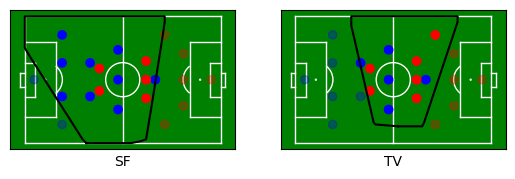

In [9]:
fig, ax = plt.subplots(1, 2)

ax[0].set_xlabel("SF")
ax[1].set_xlabel("TV")

pitch.plot(ax=ax[0])
pitch.plot(ax=ax[1])

dummy_positions[half]["Home"].plot(t=frame, color="blue", alpha=alpha_home_sf, ax=ax[0])
dummy_positions[half]["Away"].plot(t=frame, color="red", alpha=alpha_away_sf, ax=ax[0])
dummy_positions[half]["Home"].plot(t=frame, color="blue", alpha=alpha_home_tv, ax=ax[1])
dummy_positions[half]["Away"].plot(t=frame, color="red", alpha=alpha_away_tv, ax=ax[1])

if fov_sf is not None:
    if hasattr(fov_sf, "exterior"):
        fov_sf = fov_sf.simplify(0.1)
        ax[0].plot(*fov_sf.exterior.xy, color="black")
    else:
        for geom in fov_sf.geoms:
            ax[0].plot(*geom.exterior.xy, color="black")

if fov_tv is not None:
    if hasattr(fov_tv, "exterior"):
        fov_tv = fov_tv.simplify(0.1)
        ax[1].plot(*fov_tv.exterior.xy, color="black")
    else:
        for geom in fov_tv.geoms:
            ax[1].plot(*geom.exterior.xy, color="black")

_**Figure:** Example of field of views projected onto the pitch with player visibility masking applied (per source for one frame)._